In [8]:
# Imports
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import smbclient
import os
import tempfile

In [9]:
smb_server_ip = os.environ['SMB_SERVER_IP']
smb_server_port = int(os.environ['SMB_SERVER_PORT'])
smb_username = os.environ['SMB_USERNAME']
smb_password = os.environ['SMB_PASSWORD']
smb_share_name = os.environ['SMB_SHARE_NAME']

remote_term_df_path = 'term_df_compressed.csv.gz'
remote_bigram_df_path = 'bigram_df_compressed.csv.gz'

# Set the SMB client configuration with the provided credentials
smbclient.ClientConfig(username=smb_username, password=smb_password)

def download_dataframe_from_smb_server(remote_file_path):
    # Create the full remote path
    remote_path = f"\\\\{smb_server_ip}\\{smb_share_name}\\{remote_file_path}"

    # Download the compressed CSV file from the SMB share
    with tempfile.NamedTemporaryFile(mode='w+b', suffix='.csv.gz', delete=False) as temp_file:
        with smbclient.open_file(remote_path, mode='rb') as remote_file:
            temp_file.write(remote_file.read())
        temp_file_path = temp_file.name

    # Load the temporary compressed CSV file into a pandas DataFrame
    df = pd.read_csv(temp_file_path, compression='gzip')

    # Delete the temporary file
    os.unlink(temp_file_path)

    return df

# Download both DataFrames from the SMB server
term_df = download_dataframe_from_smb_server(remote_term_df_path)
bigram_df = download_dataframe_from_smb_server(remote_bigram_df_path)

In [10]:
term_df.head()

,aal,aap,aapl,aaplo,abc,abil,abl,abroad,absolut,abus,...,york,yorkbas,young,youtub,yy,zack,zackscom,zero,zone,zuckerberg
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
bigram_df.head()

,aapl amazon,aapl appl,aapl base,aapl facebook,aapl free,aapl iphon,aapl microsoft,aapl open,aapl post,aapl profit,...,yield benchmark,yield exdividend,yield rise,yield year,york time,zack consensu,zack invest,zack rank,zack research,zack stock
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
import matplotlib.pyplot as plt
def plot_explained_variance(dataframes, titles, n_components=100):
    plt.figure(figsize=(10, 6))
    
    for df, title in zip(dataframes, titles):
        svd = TruncatedSVD(n_components=n_components)
        svd.fit(df)

        explained_variance = np.cumsum(svd.explained_variance_ratio_)

        plt.plot(range(1, n_components + 1), explained_variance, label=title)
    
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()
    plt.grid()
    plt.show()

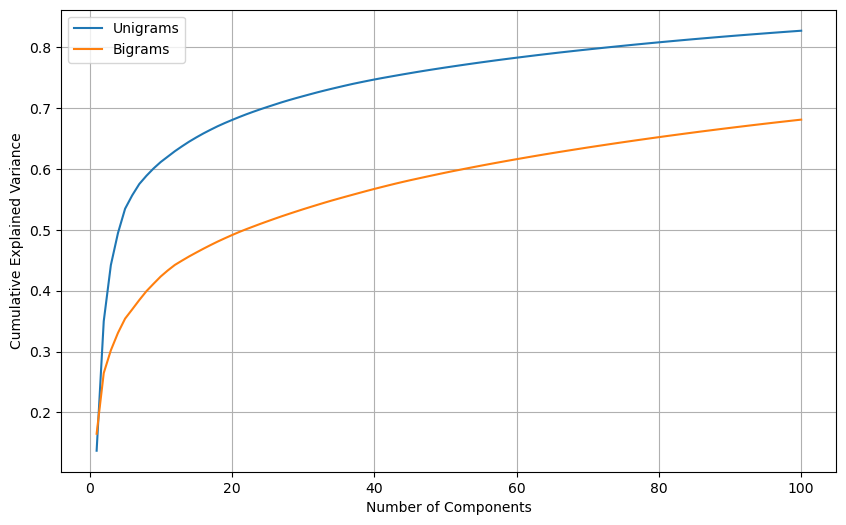

In [13]:
plot_explained_variance([term_df, bigram_df], ['Unigrams', 'Bigrams'])

In [14]:
svd_term = TruncatedSVD(n_components=20, random_state=42)
reduced_term_df = svd_term.fit_transform(term_df)

reduced_term_df = pd.DataFrame(reduced_term_df)
reduced_term_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,36.439565,-15.302190,-2.547545,-1.659895,-16.031238,-2.944297,9.061855,-0.575605,-1.958612,1.300547,1.062794,2.182119,-1.603561,-1.537616,-1.532276,0.439959,2.712686,0.687370,3.074744,0.226681
1,10.614001,-2.723702,2.190598,5.578459,9.721928,1.763540,6.098761,-5.322290,1.242681,-9.221370,4.082002,-1.774100,3.111459,3.002580,-2.236509,-2.654320,3.642550,-0.354308,-2.307327,3.374507
2,9.569055,-4.850422,-1.210971,10.470117,-11.752979,4.954493,-5.564887,2.719647,-2.249294,-5.202082,-0.026520,-2.811065,1.839078,-4.140188,0.246742,0.587204,2.289249,-0.930590,0.088894,3.043500
3,2.134139,-0.700420,-0.274912,1.806670,1.641530,-1.392696,1.281681,1.406555,-1.410188,0.208044,-0.468576,1.315296,-2.032051,-1.185378,0.714207,-1.598956,-0.238858,-0.528159,0.505135,-0.009561
4,9.642919,-3.072287,0.962490,7.076649,7.856558,-5.541051,2.874286,4.222122,-7.204744,4.778135,-6.037921,-8.550947,10.124360,2.437995,-5.370406,4.414333,2.734750,-5.325181,2.844254,0.773373


In [15]:
svd_bigram = TruncatedSVD(n_components=60, random_state=42)
reduced_bigram_df = svd_bigram.fit_transform(bigram_df)

reduced_bigram_df = pd.DataFrame(reduced_bigram_df)
reduced_bigram_df.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,15.880552,-7.906808,0.298102,3.189196,2.115635,0.170602,-2.294860,-0.759760,0.390960,7.539980,...,-1.347017,-0.890881,-0.739626,0.192083,1.806727,0.805771,-0.605036,-1.676546,1.549475,-0.957875
1,0.449039,0.400046,0.032678,-0.634296,0.593761,1.528215,-1.237550,1.954482,-2.167244,-0.114591,...,0.583089,0.432790,0.370709,1.257307,-0.377280,1.749743,-1.734565,-0.045719,-0.817956,-0.041420
2,0.117310,-0.051748,0.000652,-0.062005,-0.029863,0.547490,0.076056,0.032392,-0.117384,-0.174668,...,0.297513,-0.004511,0.161919,-0.532428,-0.397750,0.249791,0.320575,-0.181714,-0.116712,0.003585
3,0.014588,0.022518,0.001486,0.003460,-0.002483,0.186111,-0.066094,0.100822,-0.085859,-0.005144,...,-0.118442,0.052975,0.035463,-0.098559,-0.087356,0.013400,-0.207477,-0.064862,-0.030660,-0.067607
4,0.204924,0.010533,0.001234,-0.011493,-0.060196,0.492754,-0.250124,0.223621,-0.153575,0.295628,...,0.077380,0.102450,-0.021277,0.051615,-0.199628,0.067771,-0.054907,-0.107905,0.252919,0.156428


In [16]:
def save_dataframe_to_smb_server(df, remote_file_path):
    # Create a temporary file to store the compressed CSV
    with tempfile.NamedTemporaryFile(mode='w+', suffix='.csv.gz', delete=False) as temp_file:
        df.to_csv(temp_file.name, index=False, compression='gzip')
        temp_file_path = temp_file.name

    # Create the full remote path
    remote_path = f"\\\\{smb_server_ip}\\{smb_share_name}\\{remote_file_path}"

    # Upload the temporary compressed CSV file to the SMB share
    with open(temp_file_path, 'rb') as local_file:
        with smbclient.open_file(remote_path, mode='wb') as remote_file:
            remote_file.write(local_file.read())

    # Delete the temporary file
    os.unlink(temp_file_path)

# Save both DataFrames to the SMB server
save_dataframe_to_smb_server(reduced_term_df, 'term_df_compressed.csv.gz')
save_dataframe_to_smb_server(reduced_bigram_df, 'bigram_df_compressed.csv.gz')